# Model Explainability with SHAP

Model explainability refers to the ability to understand and interpret the inner workings of a machine learning model. It allows us to understand why a model makes certain predictions or decisions, and helps us to build trust in the model's outputs.

SHAP (SHapley Additive exPlanations) is a popular method for model explainability that uses the Shapley value, a concept from cooperative game theory, to assign feature importance to each input feature in a model. The Shapley value measures the marginal contribution of a feature to a prediction by comparing the predictions of all possible subsets of features with and without that feature.

To compute SHAP values, the method uses a weighted combination of feature values for each instance in the dataset. The weights are calculated based on the contribution of each feature to the model's output for that instance. The SHAP values represent the difference between the expected output of the model and the output when a particular feature is masked, indicating the impact of each feature on the model's predictions.

The SHAP values can be visualized in a variety of ways, such as bar charts, scatter plots, or summary plots. These visualizations allow us to easily interpret the impact of each feature on the model's predictions, and can help us identify which features are most important for a particular prediction.

In [ ]:
from deepmol.feature_selection import LowVarianceFS
from deepmol.splitters import SingletaskStratifiedSplitter
from deepmol.compound_featurization import MACCSkeysFingerprint
from deepmol.loaders import CSVLoader

# Load the data and create MACCS keys features, do feature selection and split into train and test sets
loader = CSVLoader(dataset_path='../data/CHEMBL217_reduced.csv',
                   smiles_field='SMILES',
                   id_field='Original_Entry_ID',
                   labels_fields=['Activity_Flag'],
                   mode='auto',
                   shard_size=2500)
# create the dataset
data = loader.create_dataset(sep=',', header=0)
train_dataset, test_dataset = SingletaskStratifiedSplitter().train_test_split(data, frac_train=0.8, seed=123)
MACCSkeysFingerprint().featurize(train_dataset, inplace=True)
MACCSkeysFingerprint().featurize(test_dataset, inplace=True)

feature_selection_method = LowVarianceFS(0.15)
feature_selection_method.fit(train_dataset)
train_df = feature_selection_method.transform(train_dataset)
test_df = feature_selection_method.transform(test_dataset)


### First, let us train a simple random forest

In [2]:
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier

# Build and train a simple RandomForest model
rf = RandomForestClassifier(n_jobs=-1, random_state=123)
model = SklearnModel(model=rf)
model.fit(train_df)

SklearnModel(model=RandomForestClassifier(n_jobs=-1, random_state=123),
             model_dir='/tmp/tmp7_v8568i')

### Compute SHAP values

#### 1. Using the DeepMol API

For computing SHAP values using DeepMol, we need to use the ShapValues class. This class takes as input the type of explainer, possible values: "auto", "permutation", "partition", "tree", or "linear". For more information on the different types of explainers, please refer to the [SHAP documentation](https://shap.readthedocs.io/en/latest/#shap.Explainer).

The default explainer is in DeepMol is "permutation", which is not limited to any specific model; it can calculate both Shapley values and Owen values for any model. Its methodology involves iterating through complete permutations of the features in both forward and reverse order. This approach allows us to minimize the number of model evaluations needed by changing one feature at a time. Consequently, we can maintain efficiency regardless of the number of executions required to approximate the feature attribution values. Although the computed SHAP values are approximations, they accurately represent the difference between the model's base value and its output for each explained instance.

In [10]:
from deepmol.feature_importance import ShapValues

# compute shap values
shap_calc = ShapValues()
shap_calc.fit(train_dataset, model)

Permutation explainer: 2001it [04:48,  6.76it/s]                          


.values =
array([[ 0.        ,  0.00333333,  0.        , ...,  0.        ,
         0.        , -0.00333333],
       [ 0.00166667,  0.00833333,  0.        , ...,  0.01333333,
         0.02666667, -0.00833333],
       [ 0.00833333,  0.00833333,  0.00166667, ..., -0.00166667,
        -0.00166667,  0.00833333],
       ...,
       [ 0.        ,  0.00333333, -0.00166667, ...,  0.        ,
        -0.01      ,  0.        ],
       [ 0.        ,  0.00666667, -0.005     , ...,  0.        ,
        -0.00666667, -0.00166667],
       [ 0.        ,  0.00333333,  0.005     , ...,  0.        ,
        -0.00166667,  0.00166667]])

.base_values =
array([0.41, 0.41, 0.41, ..., 0.41, 0.41, 0.41])

.data =
array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

#### 2. Generating plots with the DeepMol API

In each of the following plots, the x-axis represents the SHAP value for each feature, and the y-axis represents the feature's name. The color of each point indicates the value of the feature for that instance. The points are sorted by the SHAP value, with the most impactful features at the top. The plots are useful for identifying the most important features in a model, as well as the range of values for each feature. Negative values indicate that the feature value contributes to a lower prediction, while positive values indicate that the feature value contributes to a higher prediction.

#### Let's start with the beeswarm plot

Here we can see the impact of the most impactful features on the model's predictions. The x-axis represents the SHAP value for each feature, and the y-axis represents the feature's name. The color of each point indicates the value of the feature for that instance. The points are sorted by the SHAP value, with the most impactful features at the top. The beeswarm plot is useful for identifying the most important features in a model, as well as the range of values for each feature.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


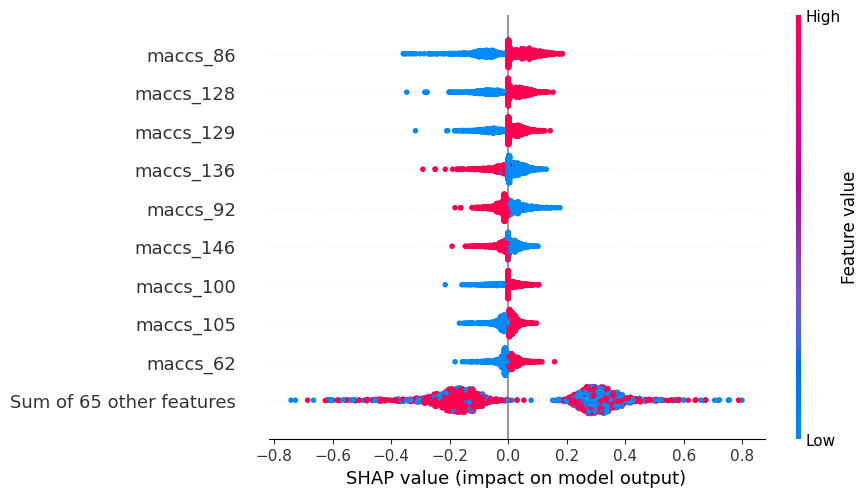

In [12]:
shap_calc.beeswarm_plot()

#### Next, let's look at the negative class plot

This plot shows the SHAP values for the negative class (inactive molecules). The x-axis represents the SHAP value for each feature, and the y-axis represents the feature's name. The color of each point indicates the value of the feature for that instance. The points are sorted by the SHAP value, with the most impactful features at the top. The negative class plot is useful for identifying the most important features in a model, as well as the range of values for each feature.

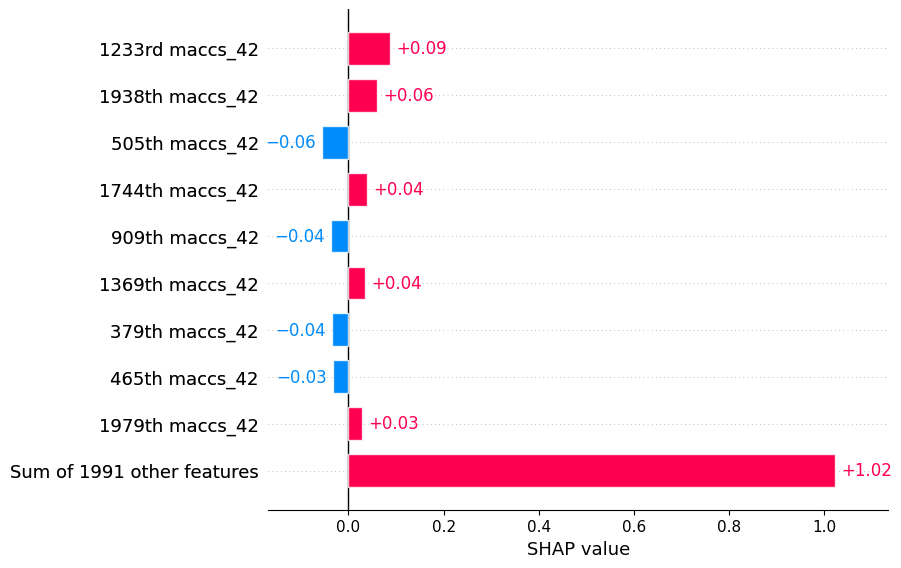

In [21]:
shap_calc.negative_class_plot()

#### Finally, let's look at the positive class plot

This plot shows the SHAP values for the positive class (active molecules). The x-axis represents the SHAP value for each feature, and the y-axis represents the feature's name. The color of each point indicates the value of the feature for that instance. The points are sorted by the SHAP value, with the most impactful features at the top. The positive class plot is useful for identifying the most important features in a model, as well as the range of values for each feature.

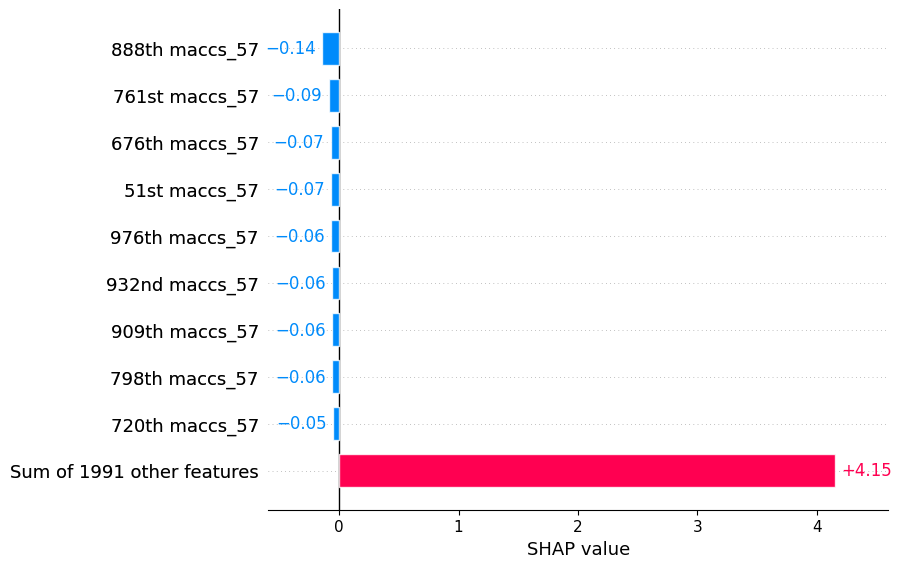

In [22]:
shap_calc.positive_class_plot()

#### We can also plot the SHAP values for a specific molecule

This plot shows the SHAP values for a specific molecule. The x-axis represents the SHAP value for each feature, and the y-axis represents the feature's name. The color of each point indicates the value of the feature for that instance. The points are sorted by the SHAP value, with the most impactful features at the top. The molecule plot is useful for identifying the most important features in a model, as well as the range of values for each feature.

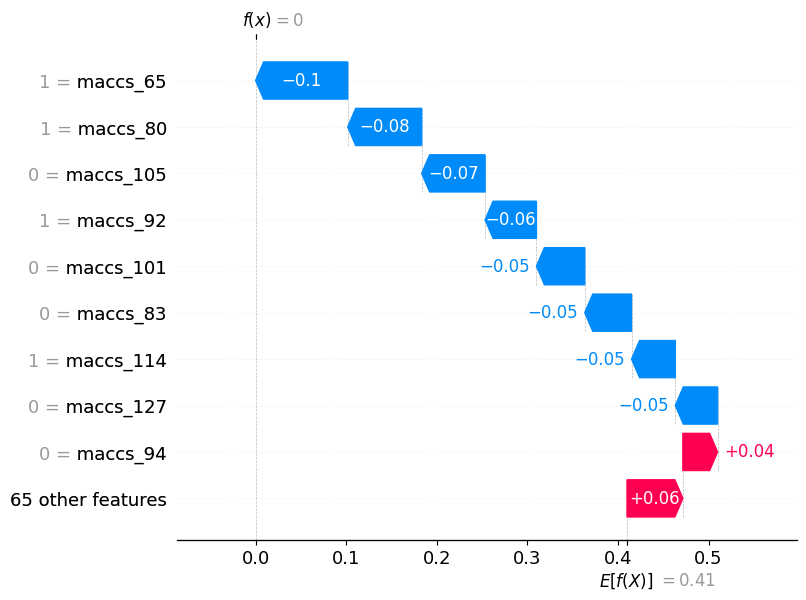

In [24]:
# check impact of features on specific molecules
shap_calc.sample_explanation_plot(index=1, plot_type='waterfall')

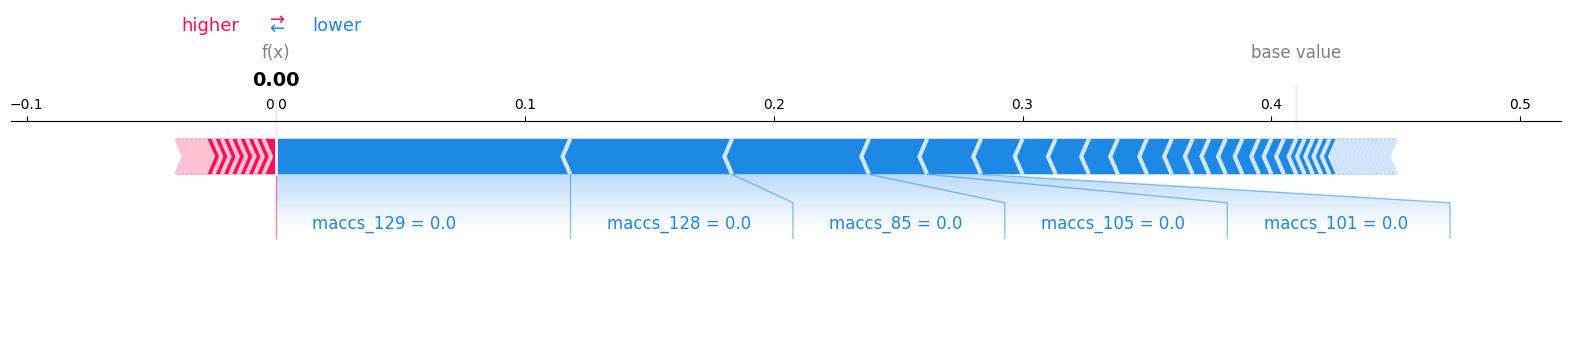

In [14]:
# just another way to plot the same thing
shap_calc.sample_explanation_plot(index=0, plot_type='force', matplotlib=True)

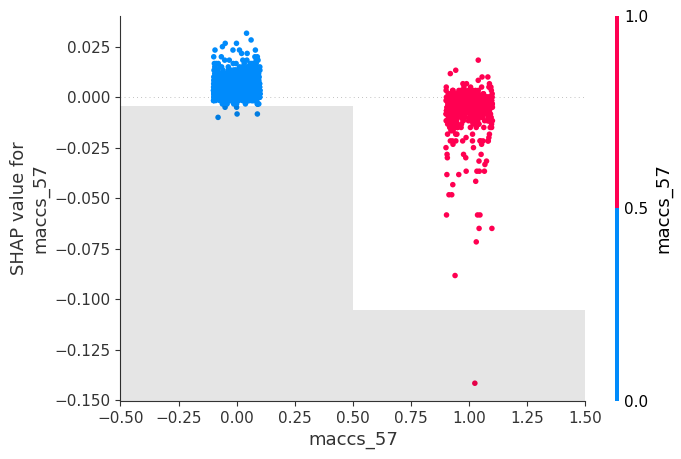

In [15]:
# if no index is passed, it plots for all features
shap_calc.feature_explanation_plot(1)

#### We can also generate a heat map of molecules vs features

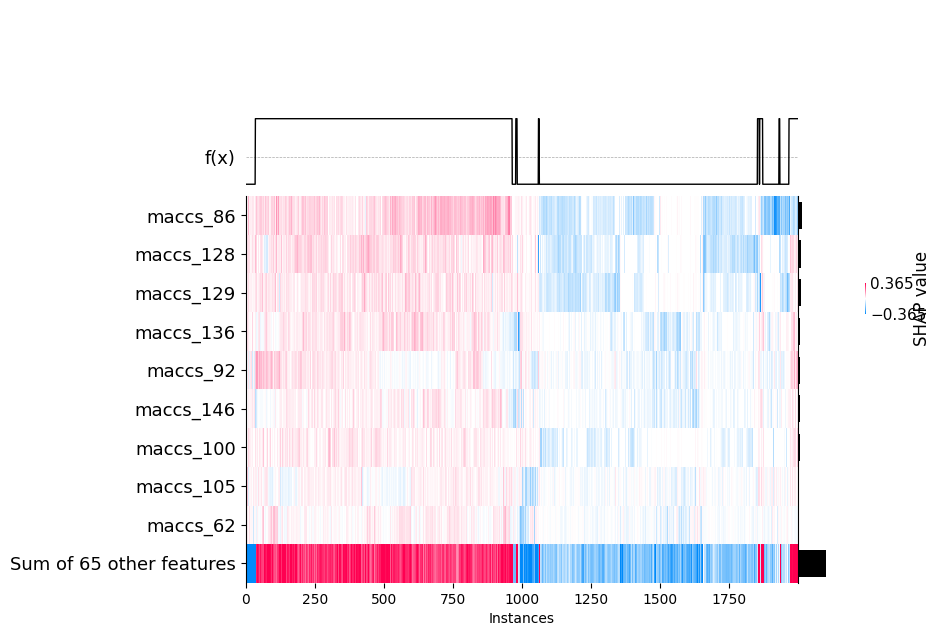

In [25]:
# heat map of molecules vs features
shap_calc.heatmap_plot()

### Draw relevant features

It is possible to plot the ON bits (or some of them) in a molecule for MACCS Keys, Morgan and RDK Fingeprints. IT is also possible to draw those bits on the respective molecule. This can be allied with the Shap Values calculation to highlight the zone of the molecule that most contributed to a certain prediction, for instance, the substructure in the molecule that most contributed to its classification as an active or inactive molecule against a receptor.

### Let's start with MACCS Keys

Prediction:  [0.19 0.81]
Actual Value:  0


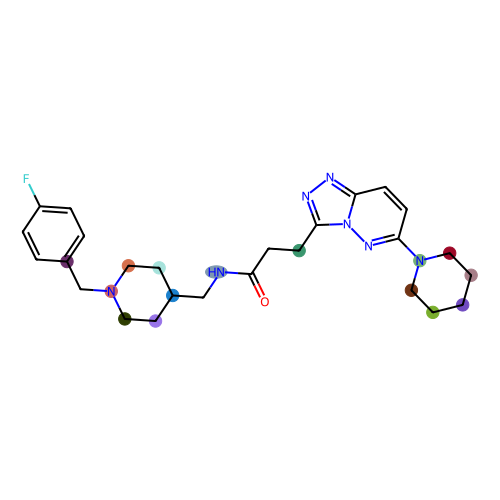

In [38]:
maccs_keys = MACCSkeysFingerprint()
# draw the relevant bits for a specific molecule
# lets check for the feature 59 (feature maccs_136) and the molecule 0
patt_number = 129
mol_number = 0

prediction = model.predict(test_df)[mol_number]
actual_value = test_df.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_df.mols[mol_number]

maccs_keys.draw_bit(smi, patt_number)

### Let's now check Morgan Fingerprint

2023-06-02 16:32:16,545 — INFO — Bit 29 with 1 hits!


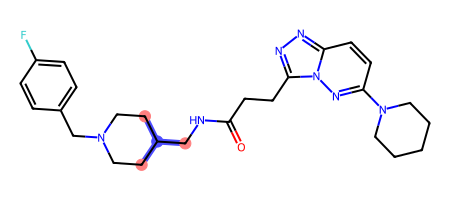

In [36]:
from deepmol.compound_featurization import MorganFingerprint

# draw the relevant bits for a specific molecule
patt_number = 29
MorganFingerprint().draw_bit(smi, patt_number)

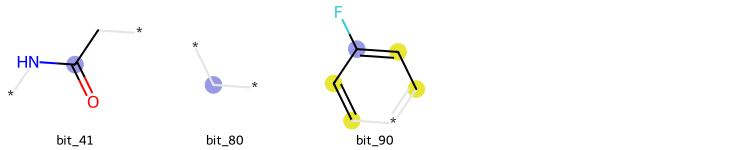

In [35]:
MorganFingerprint().draw_bits(smi, [41, 80, 90])

### Finally, let's check RDK Fingerprint

2023-06-02 16:33:37,207 — INFO — Bit 29 with 1 hits!


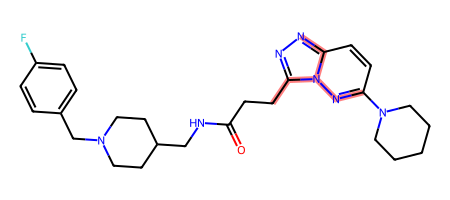

In [40]:
from deepmol.compound_featurization import RDKFingerprint

# draw the relevant bits for a specific molecule
patt_number = 29
RDKFingerprint().draw_bit(smi, patt_number)

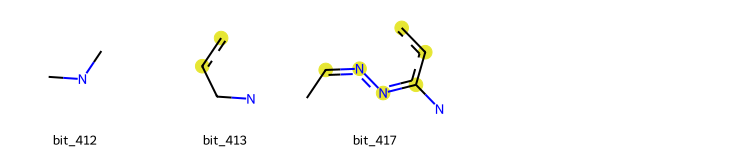

In [42]:
RDKFingerprint().draw_bits(smi, [412, 413, 417])